In [1]:
from math import sqrt,pi
import numpy as np
from scipy  import optimize
import matplotlib.pyplot as plt
#import matplotlib.pylab as plt
#from skimage.io import imread
from skimage import filters
import scipy.ndimage
import pims
from skimage.morphology import watershed , closing, square,label
from skimage.filters import threshold_otsu, sobel
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import interp1d


# Load data

In [2]:
frames = pims.ImageSequence('...*.tif', as_grey=True) 

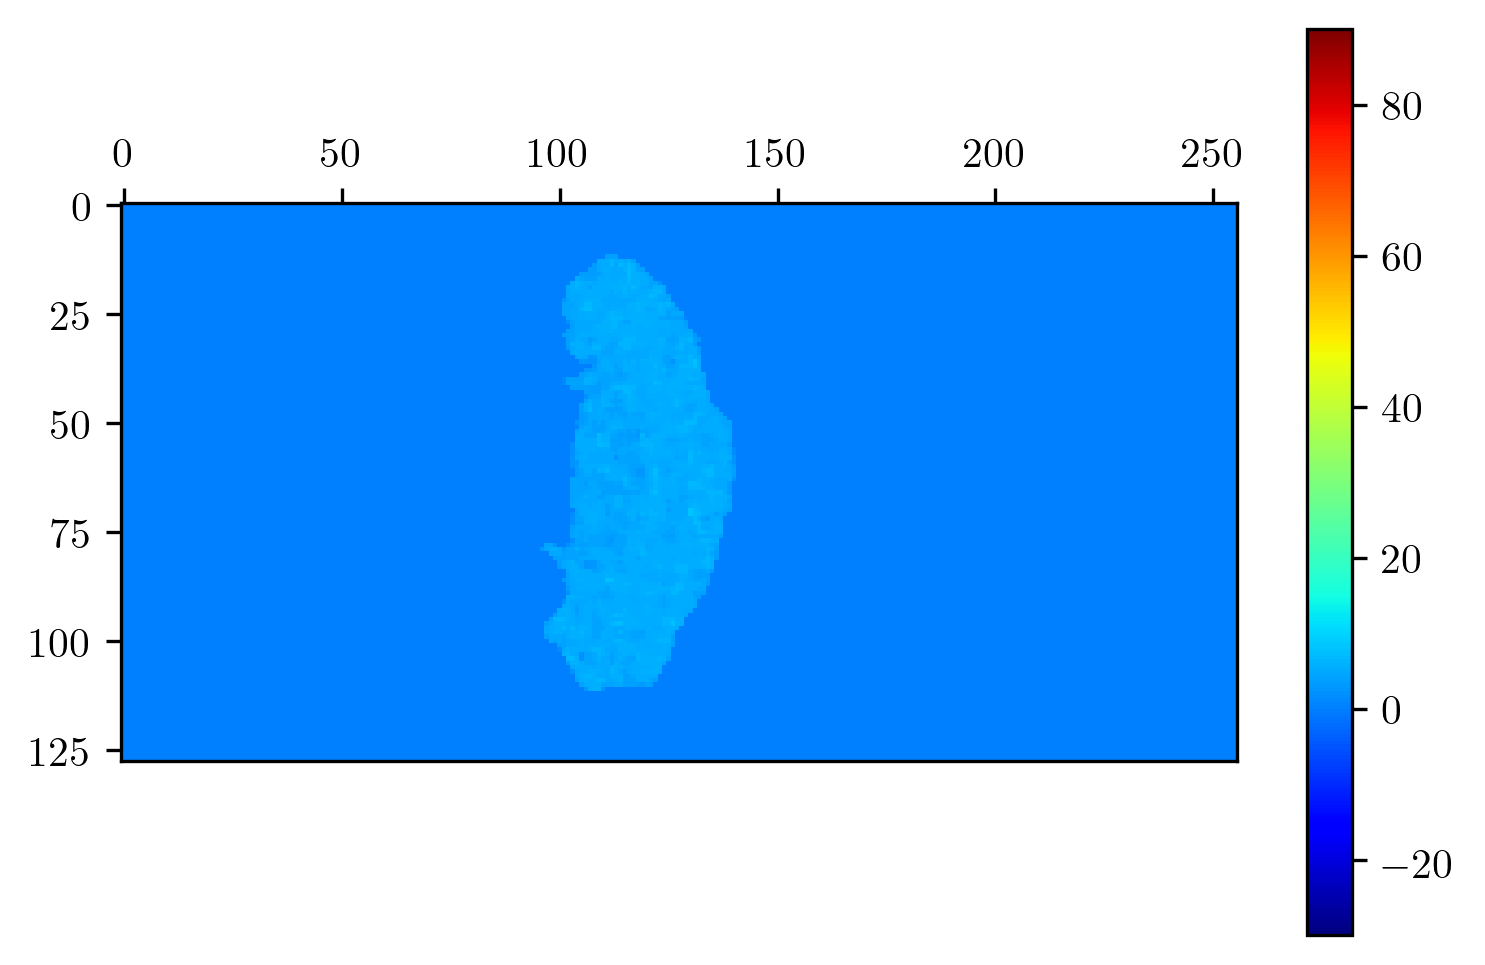

In [5]:
frame_no = 10

brightness_low = -30
brightness_up = 90
image = np.array(frames[10])



fig, ax = plt.subplots(1)
im = ax.imshow(image,  vmin= brightness_low , vmax= brightness_up, cmap=plt.cm.jet)
ax.xaxis.tick_top()
fig.colorbar(im, ax=ax)
plt.show()

# Cell front detection using Skimage package

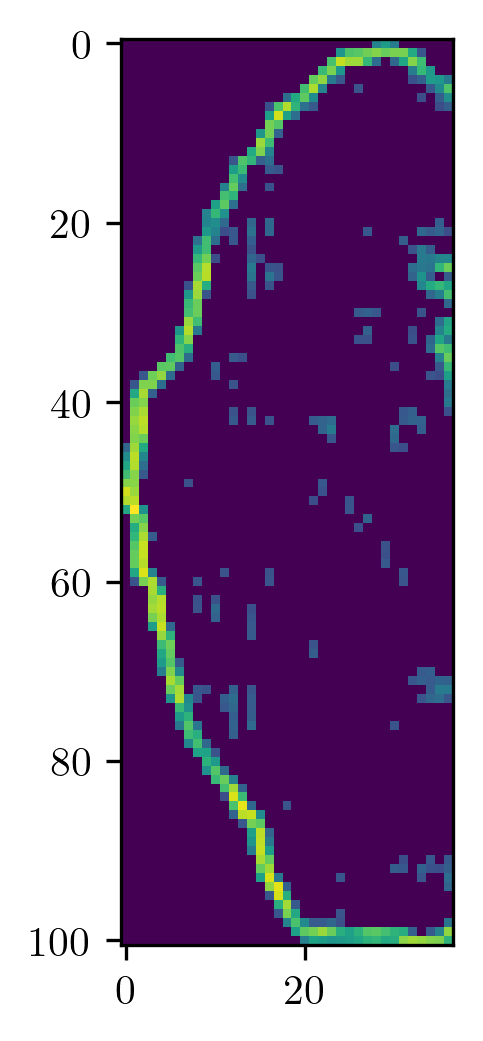

In [6]:
min_max = MinMaxScaler(copy=True, feature_range=(-1, 1))

image_scaled = min_max.fit_transform(image)


edges = sobel(image_scaled)
foreground, background = 1, 2
markers = np.zeros_like(image)
markers[image_scaled < 1.2] = foreground
markers[image_scaled > 2] = background


segmentation = watershed(image,markers)

seg1 = label(segmentation == foreground)


edges_ = np.copy(edges)

edges_[edges_ <0.35] = 0


edges_cut = edges_[11:112, 105:142]

edges_flip = np.flip(edges_cut, axis=1)

plt.figure(2)
plt.imshow(edges_flip)

# Select univalued front value

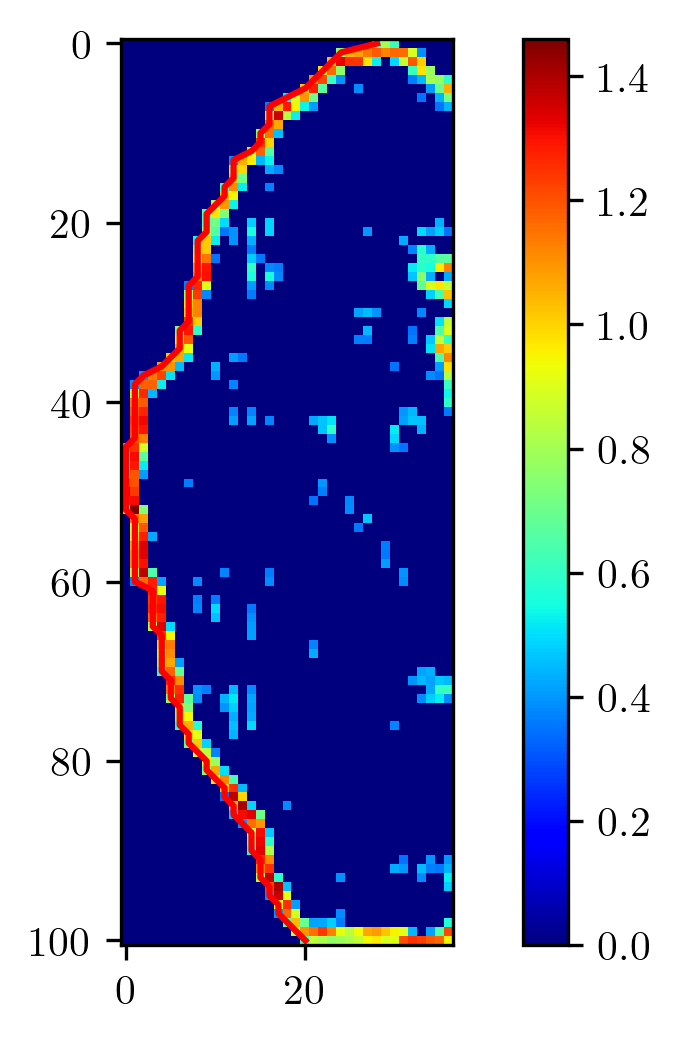

In [8]:
last_element = [] 

for k in range(len(edges_flip)):
        
    edges_cut_list = edges_flip[k].tolist()
    last_element_arr = next(iter([x for x in edges_cut_list if x > 0 ]))
    temp = edges_cut_list.index(last_element_arr)
    last_element.append(temp)


    

max_x = len(edges_cut_list)
max_y = len(edges_cut)
    
  
plt.figure(3)
img = np.zeros((max_y ,max_x +20))        

img[0,0:len(edges_cut_list)] = edges_cut[0]
plt.imshow( edges_flip,cmap = 'jet')       
#plt.title( 'position_33'+ '   ' + 'frame_' +str(frame_no))
plt.colorbar()
x_axis = np.arange(0,len(last_element),1)
plt.plot(last_element,x_axis, 'r')


# Fitting the front to a circle

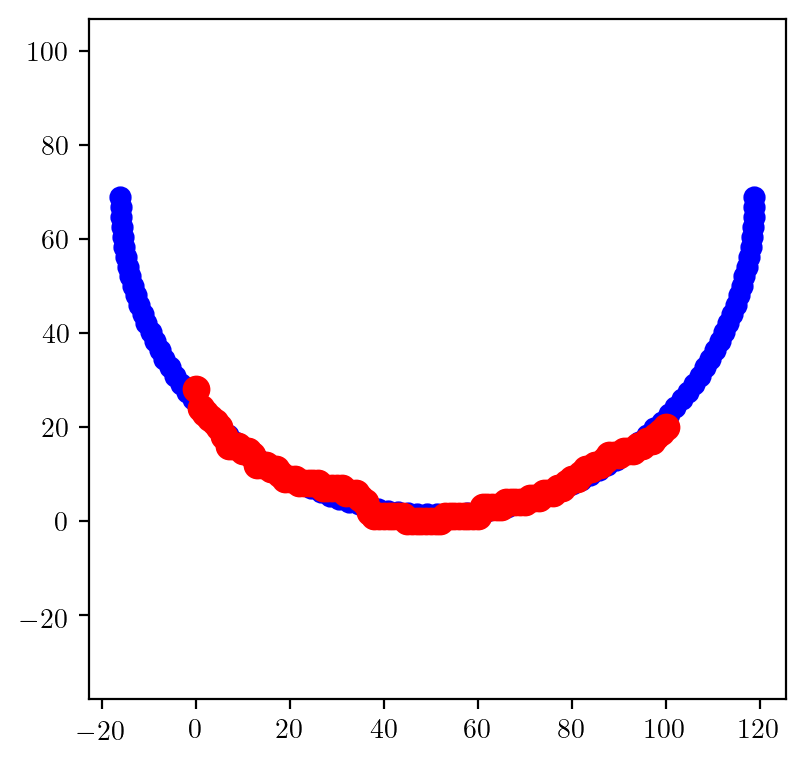

In [10]:
from numpy import *
method_2  = "least_squares"


x  = x_axis
y = np.array(last_element)

x_m = np.mean(x)
y_m = np.mean(y)

method_2  = "leastsq"

def calc_R(c):
    """ calculate the distance of each 2D points from the center c=(xc, yc) """
    return sqrt((x-c[0])**2 + (y-c[1])**2)

def f_2(c):
    """ calculate the algebraic distance between the 2D points and the mean circle centered at c=(xc, yc) """
    Ri = calc_R(c)
    return Ri - Ri.mean()

center_estimate = x_m, y_m
center_2, ier = optimize.leastsq(f_2, center_estimate)

xc_2, yc_2 = center_2
Ri_2       = calc_R(center_2)
R_2        = Ri_2.mean()
residu_2   = sum((Ri_2 - R_2)**2)
residu2_2  = sum((Ri_2**2-R_2**2)**2)



f = plt.figure(figsize=(4.5, 4.5), dpi=200, facecolor='white')
plt.axis('equal')



theta_fit = np.linspace(-pi,0, len(x))



x_fit = xc_2 + R_2*np.cos(theta_fit)
y_fit = yc_2 + R_2*np.sin(theta_fit)
plt.scatter(x_fit, y_fit, c='b'  , label=method_2, lw=2)
#plt.title( 'position_33'+ '   ' + 'frame_' +str(frame_no))
plt.plot(x, y, 'ro', label='data', ms=9, mec='r', mew=1)

 

x_fit_ = np.copy(x_fit)
y_fit_ = np.copy(y_fit)


indices_1 = np.argwhere(x_fit_ <= -1)
indices_list = indices_1.tolist()
flat_list = [item for sublist in indices_list for item in sublist]

new_x = np.delete(x_fit_, flat_list)
new_y = np.delete(y_fit_, flat_list)


f1 = interp1d(new_x, new_y,fill_value="extrapolate")

x_new = np.arange(len(x))
y_new = f1(x_new)

# Removing the value of the fitted circle to the real cell front

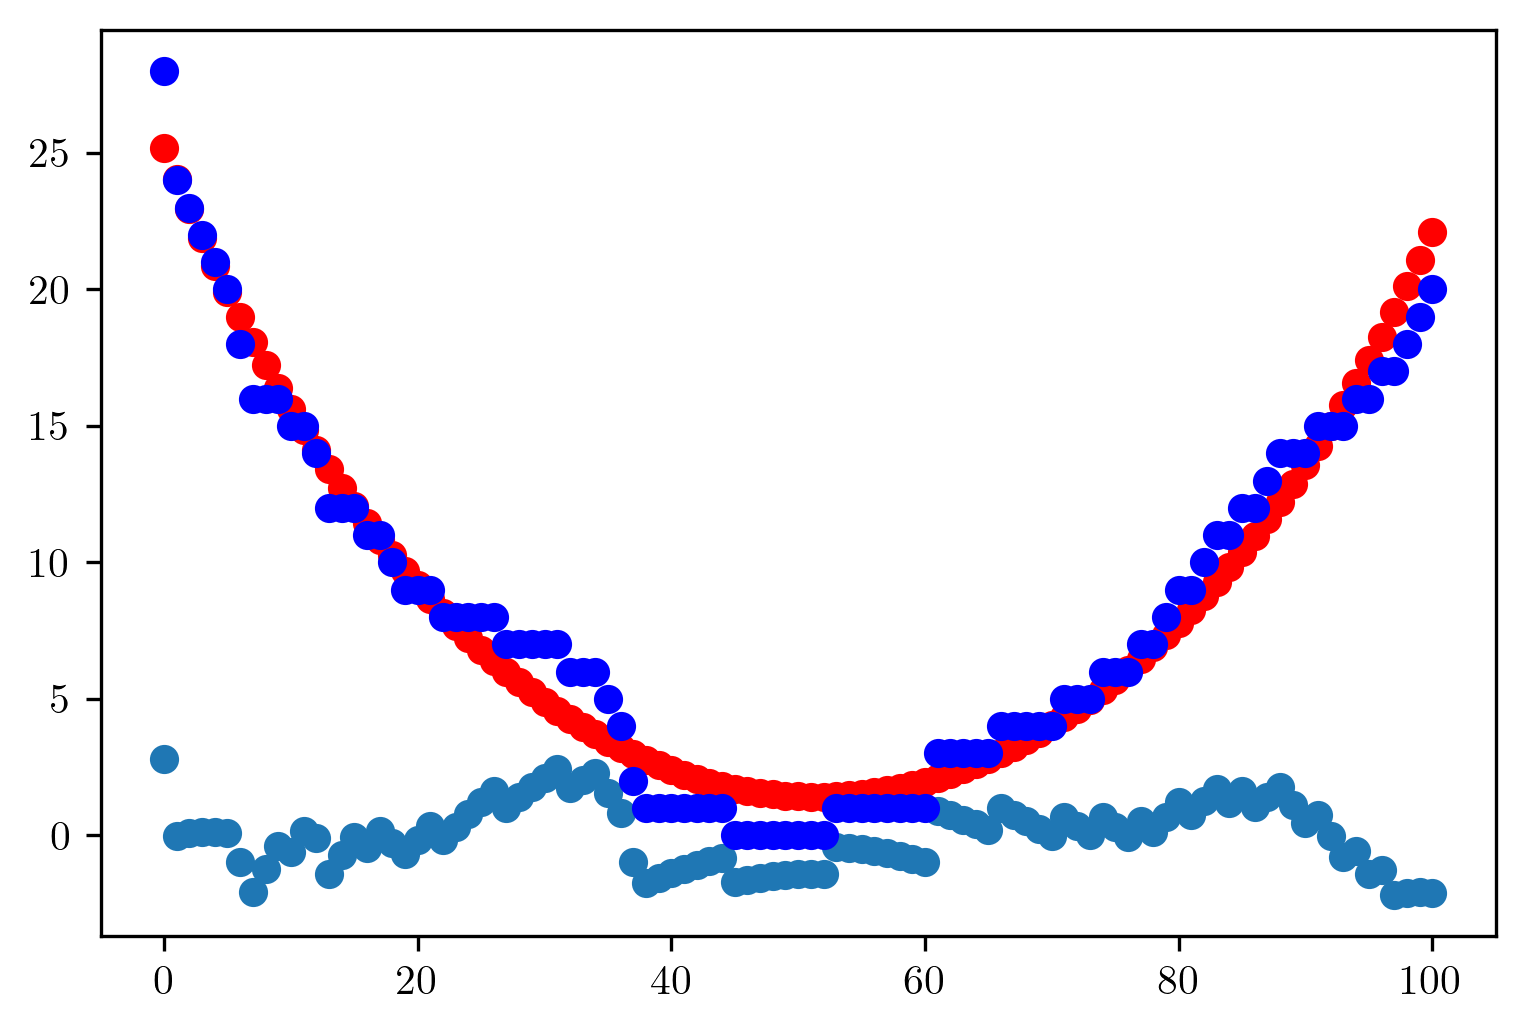

In [12]:
plt.figure(5)
#plt.title( 'position_33'+ '   ' + 'frame_' +str(frame_no))
plt.plot(x_new,y_new,'ro')
plt.plot(x,y,'bo')   

#%%

removed = []

for k in range(len(x)):
    
    value_temp = y[k]-y_new[k]
    removed.append(value_temp)

    
plt.figure(5)
#plt.title( 'position_33'+ '   ' + 'frame_' +str(frame_no))
plt.scatter(x_new,removed)    
    